In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from numpy import zeros, asarray
 
#import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# 
from tensorflow.keras.layers import LSTM, Bidirectional

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score,classification_report, roc_curve,roc_auc_score, auc

# 
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split

In [5]:
# loading the dataset
df= pd.read_csv("data/cleaned_twitter_dataset.csv")
df.sample(10)

,clean_tweet,product_updated,clean_sentiment
1558,heck wbeing sick apple supposedly set ministor...,apple,2
3231,wonder apple set makeshift shop sell ipads tom...,app,2
3239,wonder theres anyone who snag ipad supposedly ...,app,1
776,pat dont know im talk please google julia swee...,google,2
7501,apple put store downtown austin ipad tablet ap...,app,1
79,xmas rt shiny new apps new book popup ipad sto...,app,1
7966,still see two nonipad tablet thousand ipads,ipad,2
5495,arrive iphone break time lamesauce cc,iphone,1
5773,rt rt go find amp could win tech prize ipad am...,ipad,2
1279,mindtouchers give ipad demo mindtouch tcs twee...,ipad,2


In [6]:
# seperate feature and target variables
X= df["clean_tweet"]
y= df["clean_sentiment"]

In [7]:
# split data into train and test 
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42, stratify= y)

# print the shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6440,) (1610,) (6440,) (1610,)


In [8]:
# Tokenize the tweet data
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(X_train)

# features
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


# sequence
sequences = tokenizer.texts_to_sequences(X_train)

# before doing padding, we need to identify the max_length of the tweet
lengths = [len(s) for s in sequences]
print(np.percentile(lengths, [50, 75, 90, 95]))

# vocabulary length
# adding 1 to store dimensions for words which no pretrained word embedding
vocab_length = len(tokenizer.word_index)+1
print("\nVocabulary lenght:", vocab_length)

[ 9. 12. 13. 14.]

Vocabulary lenght: 7574


***
    the distribution of the tweet shows that the max_length is 16. We will therefore set the max_length = 20, to be safe.

In [9]:
# Pad the sequences
# add zeros after the actual tokens.
max_length = 20
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [10]:
# reshaping
num_samples = X_train_pad.shape[0]
num_features = X_train_pad.shape[1]

# Reshape to (num_samples, num_time_steps, num_features)
# Assuming num_time_steps = num_features for simplicity
num_time_steps = num_features
x_train_rnn = X_train_pad.reshape((num_samples, num_time_steps, 1))
x_test_rnn = X_test_pad.reshape((X_test_pad.shape[0], num_time_steps, 1))

# Verify the new shape
print("x_train_rnn shape:", x_train_rnn.shape)
print("x_test_rnn shape:", x_test_rnn.shape)

x_train_rnn shape: (6440, 20, 1)
x_test_rnn shape: (1610, 20, 1)


In [11]:
# correcting the class imbalance
# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Reshape the data to 2D for resampling (flattening only the sequence dimension)
num_samples, num_time_steps, num_features = x_train_rnn.shape
x_train_rnn_reshaped = x_train_rnn.reshape(num_samples, -1)

# Apply the oversampling
x_train_rnn_resampled, y_train_resampled = ros.fit_resample(x_train_rnn_reshaped, y_train)

# Reshape the data back to the original 3D format
x_train_rnn_resampled = x_train_rnn_resampled.reshape(-1, num_time_steps, num_features)

# Verify the shapes
print("Original shape of x_train_rnn:", x_train_rnn.shape)
print("Shape of x_train_rnn_resampled after resampling:", x_train_rnn_resampled.shape)
print("Shape of y_train_resampled after resampling:", y_train_resampled.shape)

Original shape of x_train_rnn: (6440, 20, 1)
Shape of x_train_rnn_resampled after resampling: (11082, 20, 1)
Shape of y_train_resampled after resampling: (11082,)


In [12]:
# glove
import os
import requests
import zipfile

# Download GloVe embeddings if not already available
if not os.path.exists("glove.6B.100d.txt"):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    r = requests.get(url)
    with open("glove.6B.zip", "wb") as f:
        f.write(r.content)

    # Unzip only 100d file
    with zipfile.ZipFile("glove.6B.zip", "r") as zip_ref:
        zip_ref.extract("glove.6B.100d.txt")

print("GloVe 100d file is ready!")

GloVe 100d file is ready!


In [13]:
# Load GloVe embeddings (100d). Ensure you have 'glove.6B.100d.txt' downloaded in the same folder.
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

print("Loaded word vectors:", len(embeddings_index))

Loaded word vectors: 400000


In [14]:
# Create Embedding Matrix 
# Containing 100-dimensional GloVe word embeddings for 4000 words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
# Print the shape of the embedding matrix
print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (7574, 100)


## Simple Neural Network

In [15]:
# FINAL

In [45]:
#early stoping
earldropping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [46]:
rnn_model = Sequential([Embedding(vocab_length, 100, weights=[embedding_matrix],input_length=max_length, trainable=False),
                        SimpleRNN(128, return_sequences=False),Dense(3, activation='softmax')])

rnn_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history_rnn = rnn_model.fit(x_train_rnn, y_train,epochs=25, batch_size=32,validation_split=0.2,callbacks=[earldropping])

Epoch 1/25
161/161 [==============================] - 2s 7ms/step - loss: 0.8881 - accuracy: 0.5561 - val_loss: 0.8648 - val_accuracy: 0.5637
Epoch 2/25
161/161 [==============================] - 1s 5ms/step - loss: 0.8535 - accuracy: 0.5755 - val_loss: 0.8351 - val_accuracy: 0.5699
Epoch 3/25
161/161 [==============================] - 1s 5ms/step - loss: 0.8186 - accuracy: 0.6120 - val_loss: 0.8924 - val_accuracy: 0.5621
Epoch 4/25
161/161 [==============================] - 1s 5ms/step - loss: 0.7984 - accuracy: 0.6231 - val_loss: 0.8582 - val_accuracy: 0.5870
Epoch 5/25
161/161 [==============================] - 1s 5ms/step - loss: 0.7585 - accuracy: 0.6522 - val_loss: 0.8854 - val_accuracy: 0.5606


In [47]:
# Make predictions using the rnn model
ans = rnn_model.predict(X_test_pad)

# Convert predictions to class labels
# Since it's a multi-class classification, we use argmax to get the class with the highest probability
y_pred = np.argmax(ans, axis=1)

51/51 [==============================] - 0s 2ms/step


In [49]:
# evaluating test data
loss, acc =rnn_model.evaluate(x_test_rnn, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

51/51 [==============================] - 0s 3ms/step - loss: 0.8507 - accuracy: 0.5764
Test Loss: 0.8507, Test Accuracy: 0.5764


The model is predicting correctly about 57.6% of the time on a simple rnn model.
the 57.6% accuracy shows that the model has learned some structure, but not enough to reliably distinguish classes.

There’s no overfitting, both training and test performance are similarly low. This means the issue isn’t generalization, it’s underfitting.

85% loss shows that the model is not confident in its predictions

Confusion matrix
[[  0  40  72]
 [  0 111 464]
 [  0 106 817]]



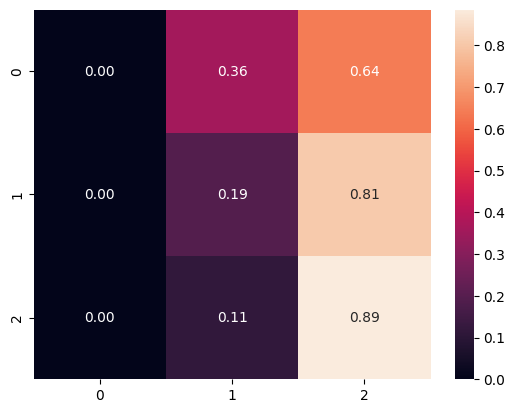

In [51]:
print(f"Confusion matrix\n{confusion_matrix(y_test, y_pred)}\n")
                                    
con=confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(con, annot=True, fmt=".2f");

The model completely fails to identify class 0.
Only 19% correctly predicted as class 1.

81% misclassified as class 2.
Model struggles to distinguish class 1, mostly confusing it with class 2.

89% correctly predicted as class 2.
A small portion (11%) misclassified as class 1.
Model performs very well for class 2

The confusion matrix shows that the model overwhelmingly predicts class 2, 
achieving high accuracy (89%) for this class but performing poorly on classes 0 and 1. 
Class 0 is never correctly identified, and 81% of class 1 samples are misclassified as class 2. 
This indicates a strong bias toward the majority class, likely due to dataset imbalance. 
To improve performance, the model would benefit from applying class weighting, oversampling the minority classes, or using a more expressive network such as an LSTM or GRU to better capture class distinctions.

Epoch 1/25
278/278 [==============================] - 2s 6ms/step - loss: 0.2959 - accuracy: 0.8733 - val_loss: 0.2896 - val_accuracy: 0.8674
Epoch 2/25
278/278 [==============================] - 1s 5ms/step - loss: 0.2651 - accuracy: 0.8917 - val_loss: 0.4203 - val_accuracy: 0.7988
Epoch 3/25
278/278 [==============================] - 1s 5ms/step - loss: 0.2786 - accuracy: 0.8844 - val_loss: 0.2674 - val_accuracy: 0.8791
Epoch 4/25
278/278 [==============================] - 1s 5ms/step - loss: 0.2392 - accuracy: 0.9014 - val_loss: 0.2661 - val_accuracy: 0.8868
Epoch 5/25
278/278 [==============================] - 1s 5ms/step - loss: 0.3341 - accuracy: 0.8685 - val_loss: 0.3327 - val_accuracy: 0.8385
Epoch 6/25
278/278 [==============================] - 1s 5ms/step - loss: 0.2463 - accuracy: 0.8962 - val_loss: 0.2547 - val_accuracy: 0.8945
Epoch 7/25
278/278 [==============================] - 1s 5ms/step - loss: 0.2007 - accuracy: 0.9204 - val_loss: 0.1432 - val_accuracy: 0.9454
Epoch 

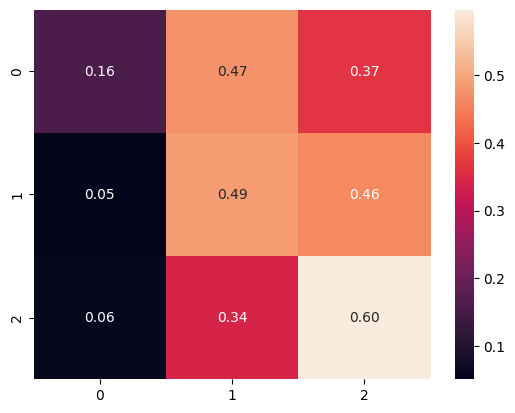

In [53]:
# correcting class imbalance
# Compile the model
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model using the resampled data
history_rnn = rnn_model.fit(
    x_train_rnn_resampled, y_train_resampled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earldropping])

# Make predictions using the rnn_model
ans = rnn_model.predict(X_test_pad)
ans_train = rnn_model.predict(X_train_pad)

# Convert predictions to class labels
y_pred = np.argmax(ans, axis=1)
y_pred_train = np.argmax(ans_train, axis=1)

print('\nTest Accuracy score', accuracy_score(y_test, y_pred))
print('Train Accuracy score', accuracy_score(y_train, y_pred_train))

print(f"Confusion matrix\n{confusion_matrix(y_test, y_pred)}\n")
                                    
con=confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(con, annot=True, fmt=".2f");

After correcting class imbalance on simple rnn model, The training accuracy (92.6%) becomes much higher than the test accuracy (52.7%).

This large gap indicates overfitting, the model learned the training data patterns very well but failed to generalize to unseen test data.

It may be memorizing training examples instead of capturing general relationships.

After addressing class imbalance, the model shows improved recognition of minority classes, particularly class 1, and reduced bias toward the dominant class 2. Although the overall test accuracy of (52%) remains moderate, the distribution of predictions is now more balanced, indicating healthier model behavior. This trade-off slightly lower accuracy but fairer class representation, reflects a positive outcome of class rebalancing. Further improvements could come from tuning the class weights, enhancing feature representations, or switching to a more expressive architecture such as an LSTM or GRU.

### LSTM

In [54]:
lstm_model = Sequential([Embedding(vocab_length, 100, weights = [embedding_matrix], input_length=max_length, trainable= False),
                         LSTM(128, return_sequences=False),
                         Dense(3, activation='softmax')])

lstm_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

history_lstm = lstm_model.fit(x_train_rnn, y_train,epochs=25,batch_size=32,validation_split=0.2,callbacks=[earldropping])

Epoch 1/25
161/161 [==============================] - 3s 13ms/step - loss: 0.8634 - accuracy: 0.5753 - val_loss: 0.8255 - val_accuracy: 0.5846
Epoch 2/25
161/161 [==============================] - 2s 10ms/step - loss: 0.8091 - accuracy: 0.6180 - val_loss: 0.7977 - val_accuracy: 0.6149
Epoch 3/25
161/161 [==============================] - 2s 10ms/step - loss: 0.7752 - accuracy: 0.6386 - val_loss: 0.7781 - val_accuracy: 0.6273
Epoch 4/25
161/161 [==============================] - 2s 10ms/step - loss: 0.7452 - accuracy: 0.6640 - val_loss: 0.8134 - val_accuracy: 0.6002
Epoch 5/25
161/161 [==============================] - 2s 11ms/step - loss: 0.7140 - accuracy: 0.6747 - val_loss: 0.7500 - val_accuracy: 0.6592
Epoch 6/25
161/161 [==============================] - 2s 11ms/step - loss: 0.6884 - accuracy: 0.6887 - val_loss: 0.7548 - val_accuracy: 0.6599
Epoch 7/25
161/161 [==============================] - 2s 11ms/step - loss: 0.6616 - accuracy: 0.6993 - val_loss: 0.7587 - val_accuracy: 0.6530

In [55]:
# Make predictions using the LSTM model
ans = lstm_model.predict(X_test_pad)

# Convert predictions to class labels
# Since it's a multi-class classification, we use argmax to get the class with the highest probability
y_pred = np.argmax(ans, axis=1)

51/51 [==============================] - 1s 5ms/step


202/202 [==============================] - 1s 5ms/step

Test Accuracy score 0.6285714285714286
Train Accuracy score 0.69472049689441
Confusion matrix
[[ 16  30  66]
 [  4 288 283]
 [ 14 201 708]]



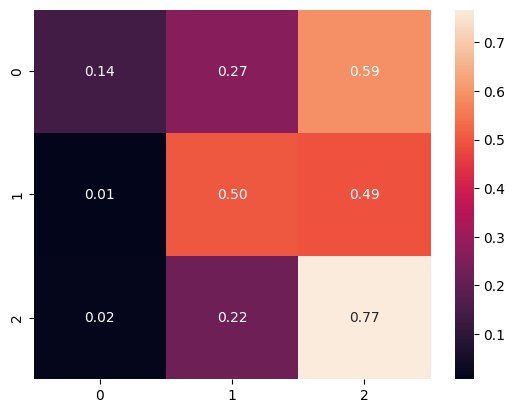

In [58]:
# Make predictions using the rnn_model
ans = lstm_model.predict(X_test_pad)
ans_train = lstm_model.predict(X_train_pad)

# Convert predictions to class labels
y_pred = np.argmax(ans, axis=1)
y_pred_train = np.argmax(ans_train, axis=1)

print('\nTest Accuracy score', accuracy_score(y_test, y_pred))
print('Train Accuracy score', accuracy_score(y_train, y_pred_train))

print(f"Confusion matrix\n{confusion_matrix(y_test, y_pred)}\n")
                                    
con=confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(con, annot=True, fmt=".2f");

The LSTM model achieved a training accuracy of 69.5% and a test accuracy of 62.9%, showing a relatively small gap between training and testing performance. This indicates that the model generalizes well and is less overfitted compared to earlier RNN models, which exhibited a larger accuracy gap


The confusion matrix shows that the model performs best when predicting positive sentiments (77%), but struggles to accurately classify negative and neutral tweets. Most negative tweets are incorrectly labeled as positive (59%), and nearly half of the neutral ones are also misclassified as positive (49%). This indicates a bias toward the positive class, possibly due to class imbalance or overlapping language patterns between neutral and positive sentiments. The model needs further tuning such as rebalancing the dataset or enhancing feature representation to better distinguish between negative and neutral tones.

Epoch 1/25
278/278 [==============================] - 6s 16ms/step - loss: 0.7282 - accuracy: 0.6799 - val_loss: 0.6959 - val_accuracy: 0.6689
Epoch 2/25
278/278 [==============================] - 5s 17ms/step - loss: 0.6046 - accuracy: 0.7382 - val_loss: 0.6239 - val_accuracy: 0.6797
Epoch 3/25
278/278 [==============================] - 5s 18ms/step - loss: 0.5678 - accuracy: 0.7533 - val_loss: 0.4677 - val_accuracy: 0.7866
Epoch 4/25
278/278 [==============================] - 5s 19ms/step - loss: 0.4734 - accuracy: 0.7932 - val_loss: 0.5947 - val_accuracy: 0.7140
Epoch 5/25
278/278 [==============================] - 5s 17ms/step - loss: 0.4288 - accuracy: 0.8123 - val_loss: 0.7886 - val_accuracy: 0.5521
Epoch 6/25
278/278 [==============================] - 5s 18ms/step - loss: 0.4159 - accuracy: 0.8148 - val_loss: 0.4005 - val_accuracy: 0.8033
Epoch 7/25
278/278 [==============================] - 5s 18ms/step - loss: 0.3827 - accuracy: 0.8270 - val_loss: 0.3448 - val_accuracy: 0.8502

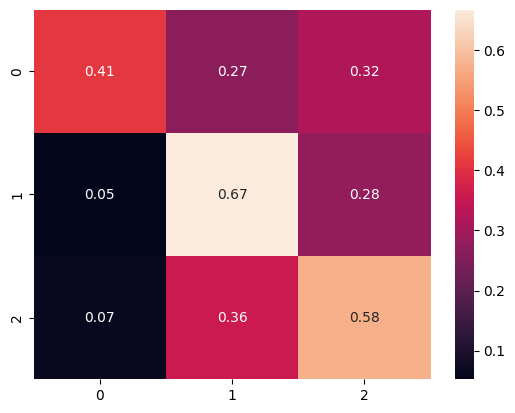

In [59]:
# correcting class imbalance
# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model using the resampled data
history_rnn = lstm_model.fit(
    x_train_rnn_resampled, y_train_resampled,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earldropping])

# Make predictions using the rnn_model
ans = lstm_model.predict(X_test_pad)
ans_train = lstm_model.predict(X_train_pad)

# Convert predictions to class labels
y_pred = np.argmax(ans, axis=1)
y_pred_train = np.argmax(ans_train, axis=1)

print('\nTest Accuracy score', accuracy_score(y_test, y_pred))
print('Train Accuracy score', accuracy_score(y_train, y_pred_train))

print(f"Confusion matrix\n{confusion_matrix(y_test, y_pred)}\n")
                                    
con=confusion_matrix(y_test, y_pred, normalize="true")
sns.heatmap(con, annot=True, fmt=".2f");

After addressing class imbalance, the LSTM model achieved a training accuracy of 79.1% and a test accuracy of 59.7%, indicating some degree of overfitting. 

Although rebalancing improved prediction consistency across classes, the model still leans toward predicting positive sentiment, suggesting lingering class dominance or overlapping linguistic patterns between neutral and positive text. Further tuning such as dropout regularization, deeper embeddings, or contextual embeddings (e.g. BERT) could help narrow the gap between training and test performance.

The normalized confusion matrix shows that the LSTM model’s classification performance has become more balanced after correcting for class imbalance. The model now correctly predicts 41% of negative, 67% of neutral, and 58% of positive tweets. Misclassifications have reduced, especially for the neutral class, which now shows the highest accuracy and less confusion with positive tweets.